In [1]:
import numpy as np

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func

from mlgrad import erm_fg, erm_irgd, fg, weights, erisk2, erisk22, sg, erm_sg

import mlgrad.af as af

from pprint import pprint

from axon import loads, dumps
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from random import randint

In [2]:
digits = load_digits()
X, Y = digits.data, digits.target
print(X.shape)
scaler = MinMaxScaler()
Xt = scaler.fit_transform(X)

(1797, 64)


In [3]:
def add_sigmaneuron_layer(nn, n_input, n_output):
    nn.add(model.LinearLayer(n_input, n_output))
    nn.add(model.ScaleLayer(func.Sigmoidal(3.0), n_output))

def add_linear_layer(nn, n_input, n_output):
    nn.add(model.LinearLayer(n_input, n_output))


In [4]:
def binarize(Y, n):
    N = len(Y)
    data = np.zeros((N,n), 'd')
    rows = []
    for k in range(N):
        data[k, Y[k]] = 1
    data = 2*data-1
    return data

Ys = binarize(Y, 10)
print(Ys.shape, Xt.shape)

(1797, 10) (1797, 64)


In [5]:
result = {}

In [6]:
n_input = 64
n_hidden = 20
def create_nn(n_input = 64, n_hidden = 30):
    ffnn = model.FFNetworkModel()
    add_sigmaneuron_layer(ffnn, n_input, n_hidden)
    add_sigmaneuron_layer(ffnn, n_hidden, 10)

    ffnn.allocate()
    return ffnn

def clf_func(ffnn, x):
    return (np.sign(ffnn(x))+1)/2

# def margin_func(ffnn, x, y):
#     u = ffnn(x)
#     j =  np.argmax(np.sign(u))
#     if j == y:
#         return np.abs(u[j])
#     else:
#         return -np.abs(u[j])        

In [7]:
q = 0.10
Q = int(100*q)

N = len(Y)
N_q = int(q*N)

rep_dict = {0:8, 1:7, 2:7, 3:8, 4:9, 5:6, 6:8, 7:1, 8:0, 9:8}

Y_o = Y.copy()
Is = np.random.permutation(range(N))

for i in Is[:N_q]:
    Y_o[i] = rep_dict[Y_o[i]]

Ys_o = binarize(Y_o, 10)

print(N_q, np.sum(Y_o != Y), np.sum(Ys_o != Ys)//2)

179 179 179


In [8]:
ffnn0 = create_nn(n_input, n_hidden)
ffnn0.param[:] = np.random.random(size=ffnn0.n_param)

In [9]:
ffnn1 = create_nn(n_input, n_hidden)
ffnn1.param[:] = np.random.random(size=ffnn1.n_param)

In [10]:
ffnn2 = create_nn(n_input, n_hidden)
ffnn2.param[:] = np.random.random(size=ffnn2.n_param)

In [11]:
loss_func0 = loss.ErrorMultLoss2()
er0 = erisk22(Xt, Ys_o, ffnn0, loss_func0)
fg0 = erm_fg(er0, h=0.5, tol=1.0e-6, n_iter=1000)

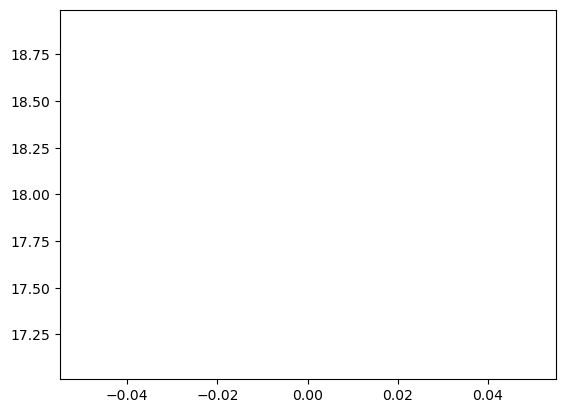

In [12]:
plt.plot(fg0.lvals)

In [13]:
# np.sum([clf_func(ffnn0, x) == y for x,y in zip(Xt,Y)])/len(Y)
# print([clf_func(ffnn0, x) for x in Xt])

In [14]:
loss_func1 = loss.ErrorMultLoss2()
er1 = erisk22(Xt, Ys_o, ffnn1, loss_func1)
fg1 = erm_fg(er1, h=0.01, tol=1.0e-6, n_iter=1000)

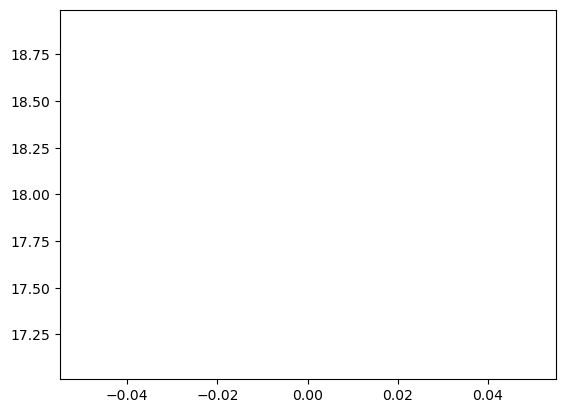

In [15]:
plt.plot(fg1.lvals)

In [16]:
np.sum([clf_func(ffnn1, x) == y for x,y in zip(Xt,Y)])/len(Y)

1.0127991096271565

In [17]:
loss_func2 = loss.ErrorMultLoss2()
er2 = erisk22(Xt, Ys_o, ffnn2, loss_func2)
fg2 = fg(er2, h=0.005, tol=1.0e-8, n_iter=1000)
avg2 = af.averaging_function("WM", func.QuantileFunc(0.6, func.Sqrt(0.001)), )
wg2 = weights.MWeights22(avg2, er2)
alg = erm_irgd(fg2, wg2, n_iter=12)

18.0


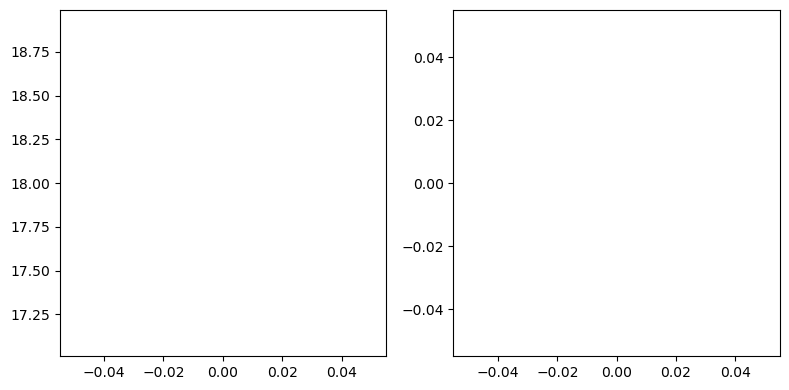

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(alg.lvals)
plt.subplot(1,2,2)
plt.plot(alg.n_iters)
plt.tight_layout()
plt.show()

In [19]:
np.sum([clf_func(ffnn2, x) == y for x,y in zip(Xt,Y)])/len(Y)

1.0127991096271565

In [20]:
# U = [margin_func(ffnn2, x, y) for x, y in zip(Xt, Y)]
# U = sorted(U)

# plt.plot(U)
# plt.hlines(0, 0, 1750)
# plt.show()

In [21]:
result[Q] = {
    'nn':(ffnn0, ffnn1, ffnn2),
    'title':(
        'AM / $r^2$ / %s%%' % Q,
        'AM / $|r|$ / %s%%' % Q,
        'WM$_{%.2f}$ / $r^2$ / %s%%' % (1.1-q, Q) ),
}

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
0 0
9 0
5 0
5 0
6 0
5 0
0 0
9 0
8 0
9 0
8 0
4 0
1 0
7 0
7 0
3 0
5 0
1 0
0 0
0 0
2 0
2 0
7 0
8 0
2 0
0 0
1 0
2 0
6 0
3 0
3 0
7 0
3 0
3 0
4 0
6 0
6 0
6 0
4 0
9 0
1 0
5 0
0 0
9 0
5 0
2 0
8 0
2 0
0 0
0 0
1 0
7 0
6 0
3 0
2 0
1 0
7 0
4 0
6 0
3 0
1 0
3 0
9 0
1 0
7 0
6 0
8 0
4 0
3 0
1 0
4 0
0 0
5 0
3 0
6 0
9 0
6 0
1 0
7 0
5 0
4 0
4 0
7 0
2 0
8 0
2 0
2 0
5 0
7 0
9 0
5 0
4 0
8 0
8 0
4 0
9 0
0 0
8 0
9 0
8 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
0 0
9 0
5 0
5 0
6 0
5 0
0 0
9 0
8 0
9 0
8 0
4 0
1 0
7 0
7 0
3 0
5 0
1 0
0 0
0 0
2 0
2 0
7 0
8 0
2 0
0 0
1 0
2 0
6 0
3 0
3 0
7 0
3 0
3 0
4 0
6 0
6 0
6 0
4 0
9 0
1 0
5 0
0 0
9 0
5 0
2 0
8 0
2 0
0 0
0 0
1 0
7 0
6 0
3 0
2 0
1 0
7 0
3 0
1 0
3 0
9 0
1 0
7 0
6 0
8 0
4 0
3 0
1 0
4 0
0 0
5 0
3 0
6 0
9 0
6 0
1 0
7 0
5 0
4 0
4 0
7 0
2 0
8 0
2 0
2 0
5 0
5 0
4 0
8 0
8 0


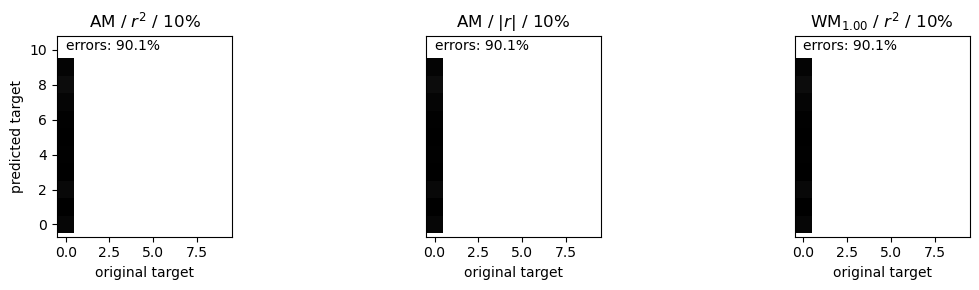

In [22]:
m_q = len(result)
plt.figure(figsize=(12.0, m_q * 3.0))
for j, Q in enumerate(result):
    for i in range(3):
        current = result[Q]
        plt.subplot(m_q, 3, 3*j+i+1)
        _ffnn = current['nn'][i]
        Y1 = np.array([np.argmax(clf_func(_ffnn, x)) for x in Xt])
        title = current['title'][i]
        
        image = np.zeros((10,10), 'd')
        for k,l in zip(Y, Y1):
            print(k,l)
            image[int(k),int(l)] += 1.0
        plt.title(title)
        plt.plot(0, 9, c='k')
        plt.imshow(image, cmap=plt.cm.gray_r)
        c = sum(Y != Y1) / len(Y) * 100
        plt.ylim(-0.7, 10.8)
        plt.text(0, 10, r'errors: %.1f%%' % c)
        if i == 0:
            plt.ylabel("predicted target")
        else:
            plt.yticks([], [])
        if j == m_q-1:
            plt.xlabel("original target")
        if j < m_q-1:
            plt.xticks([], [])
        #plt.minorticks_on()
plt.tight_layout()
# plt.savefig(r"fig/isnn2018_digits_robust_%s.pdf" % n_hidden)
plt.show()